In [12]:
import pykitti
import numpy as np
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
from scipy.spatial.transform import Rotation as R
degree = 30
R_oxts_cam = np.array(R.from_euler('z', degree, degrees=True).as_matrix())

sys.path.append('../')
from vo_funcs import *
data_dir = '../data' 
# date = '2011_10_03'
# drive = '0027'
data = pykitti.raw(data_dir, '2011_09_26', '0001')

In [17]:
len(data.timestamps)

108

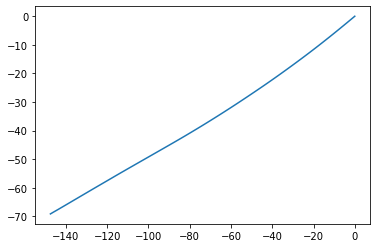

In [14]:
x, y, z = [], [], []
R, t_start = pykitti.utils.pose_from_oxts_packet(data.oxts[0].packet, scale=1)
for i in range(len(data.timestamps)):
    R, t = pykitti.utils.pose_from_oxts_packet(data.oxts[i].packet, scale=1)
    t -=t_start
    # print(t)
    x.append(t[0])
    y.append(t[1])
    z.append(t[2])
# plt.axes(projection='3d')
plt.plot(x,y)
plt.show()

In [19]:
data.oxts[0].packet.vn

-6.811441479104

In [20]:

# dataset.calib:         Calibration data are accessible as a named tuple
# dataset.timestamps:    Timestamps are parsed into a list of datetime objects
# dataset.oxts:          List of OXTS packets and 6-dof poses as named tuples
# dataset.camN:          Returns a generator that loads individual images from camera N
# dataset.get_camN(idx): Returns the image from camera N at idx  
# dataset.gray:          Returns a generator that loads monochrome stereo pairs (cam0, cam1)
# dataset.get_gray(idx): Returns the monochrome stereo pair at idx  
# dataset.rgb:           Returns a generator that loads RGB stereo pairs (cam2, cam3)
# dataset.get_rgb(idx):  Returns the RGB stereo pair at idx  
# dataset.velo:          Returns a generator that loads velodyne scans as [x,y,z,reflectance]
# dataset.get_velo(idx): Returns the velodyne scan at idx  

point_velo = np.array([0,0,0,1])
point_cam0 = data.calib.T_cam0_velo.dot(point_velo)

point_imu = np.array([0,0,0,1])
point_w = [o.T_w_imu.dot(point_imu) for o in data.oxts]

for cam0_image in data.cam0:
    # do something
    pass

cam2_image, cam3_image = data.get_rgb(3)

In [1]:
data.oxts[0]['vf']

NameError: name 'data' is not defined

In [22]:
P0 = data.calib.P_rect_00
P1 = data.calib.P_rect_10
print(data.calib.P_rect_00, data.calib.P_rect_10)

[[721.5377   0.     609.5593   0.    ]
 [  0.     721.5377 172.854    0.    ]
 [  0.       0.       1.       0.    ]] [[ 721.5377    0.      609.5593 -387.5744]
 [   0.      721.5377  172.854     0.    ]
 [   0.        0.        1.        0.    ]]


(1242, 375)


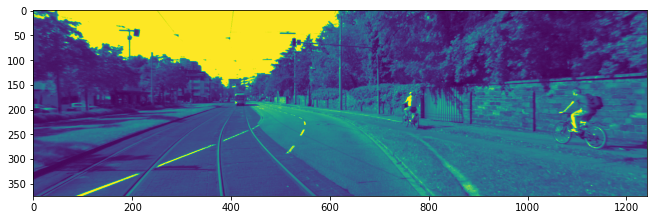

In [23]:
# This is the first left image
plt.figure(figsize=(11,7))
plt.imshow(data.get_cam0(0))
print(data.get_cam0(0).size)

Time to compute disparity map using StereoBM 0:00:00.068465


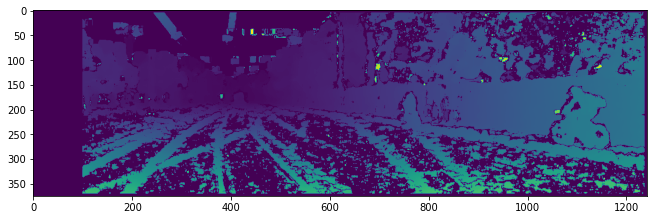

In [24]:
disp = compute_left_disparity_map(np.array(data.get_cam0(0)),
                                  np.array(data.get_cam1(0)),
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM 0:00:00.138636


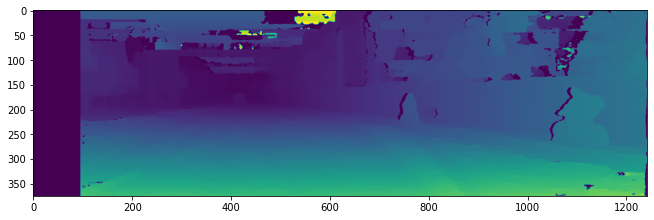

In [25]:
disp = compute_left_disparity_map(np.array(data.get_cam0(0)),
                                  np.array(data.get_cam1(0)),
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

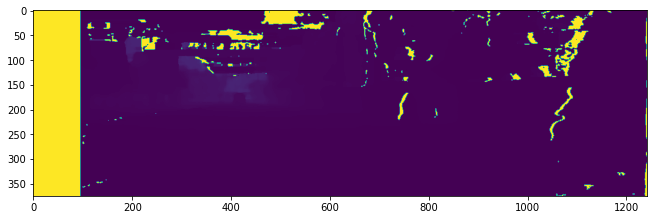

In [26]:
k_left, r_left, t_left = decompose_projection_matrix(P0)
k_right, r_right, t_right = decompose_projection_matrix(P1)

depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.grid(False)
plt.imshow(depth)

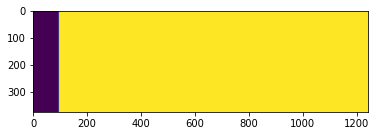

In [27]:
# We can constuct a mask using this information like so
mask = np.zeros(depth.shape, dtype=np.uint8)
ymax = depth.shape[0]
xmax = depth.shape[1]
cv2.rectangle(mask, (96, 0), (xmax, ymax), (255), thickness=-1)
plt.imshow(mask);

Time to compute disparity map using StereoSGBM 0:00:00.179817


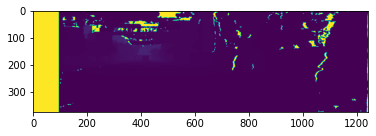

In [28]:
depth = stereo_2_depth(np.array(data.get_cam0(0)),
                       np.array(data.get_cam1(0)),
                       P0,
                       P1,
                       matcher='sgbm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(depth)

In [29]:
data.get_velo(0).shape

(121080, 4)

In [30]:
pcloud = data.get_velo(0)
print('full pcloud shape', pcloud.shape)
trimmed_pcloud = pcloud[pcloud[:, 0] > 0]
print('trimmed pcloud shape', trimmed_pcloud.shape)
print(data.calib.T_cam0_velo.round())

full pcloud shape (121080, 4)
trimmed pcloud shape (61794, 4)
[[ 0. -1. -0. -0.]
 [ 0.  0. -1. -0.]
 [ 1.  0.  0. -0.]
 [ 0.  0.  0.  1.]]


In [31]:
data.calib.T_cam0_velo
hom_pcloud = np.hstack([trimmed_pcloud[:, :3], np.ones(trimmed_pcloud.shape[0]).reshape((-1,1))])
Tr = data.calib.T_cam0_velo[:3]
cam_xyz = Tr.dot(trimmed_pcloud.T)
#cam_xyz /= cam_xyz[2]
cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
projection = P0.dot(cam_xyz)
projection /= projection[2]
projection[:, :5].T

array([[607.99996712, 153.08839962,   1.        ],
       [606.86425022, 153.08697462,   1.        ],
       [604.59974846, 153.11890506,   1.        ],
       [602.33876752, 153.10319661,   1.        ],
       [600.06802726, 153.02133285,   1.        ]])

Time to compute disparity map using StereoSGBM 0:00:00.149179


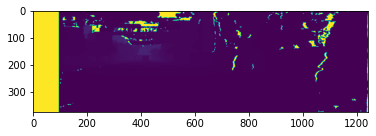

In [32]:
stereo_depth = stereo_2_depth(
                        np.array(data.get_cam0(0)),
                       np.array(data.get_cam1(0)),
                       P0,
                       P1,
                       matcher='sgbm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(depth)

In [33]:
imHeight, imWidth = np.array(data.get_cam0(0)).shape
render = pointcloud2image(data.get_velo(0), 
                          imHeight,
                          imWidth,
                          data.calib.T_cam0_velo[:3],
                          P0
                         )

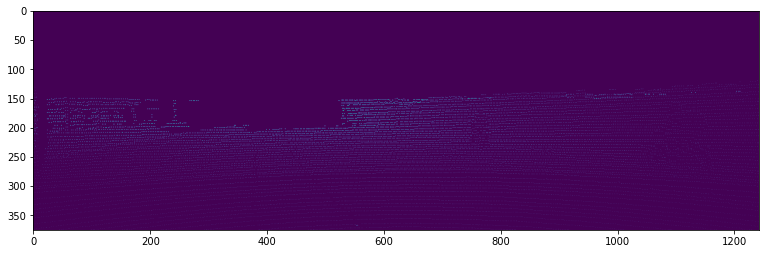

In [34]:
plt.figure(figsize=(13,5))
plt.imshow(render)

In [35]:
for i, d in enumerate(stereo_depth[200:, :].flatten()):
    if render[200:, :].flatten()[i] == 0:
        continue
    print('Stereo Depth:', d, 'Lidar Depth:', render[200:, :].flatten()[i])
    if i > 1000:
        break

Stereo Depth: 3875.7439422469133 Lidar Depth: 29.097069259233166
Stereo Depth: 3875.7439422469133 Lidar Depth: 29.145062247898718
Stereo Depth: 3875.7439422469133 Lidar Depth: 46.53300343852437
Stereo Depth: 43.364967832167814 Lidar Depth: 51.8297581363846
Stereo Depth: 48.071243410852695 Lidar Depth: 57.860344242555065
Stereo Depth: 47.701464615384594 Lidar Depth: 57.9003304621174
Stereo Depth: 47.701464615384594 Lidar Depth: 57.88833738690831
Stereo Depth: 46.97871515151513 Lidar Depth: 57.98531778903741
Stereo Depth: 43.67035492957745 Lidar Depth: 46.07318945093802
Stereo Depth: 43.98007375886523 Lidar Depth: 47.94463022018564
Stereo Depth: 44.29421714285713 Lidar Depth: 45.96121088323104
Stereo Depth: 44.936162318840566 Lidar Depth: 47.33579697561006
Stereo Depth: 44.936162318840566 Lidar Depth: 50.49785242417599
Stereo Depth: 44.936162318840566 Lidar Depth: 50.51784035185079
Stereo Depth: 44.61288057553955 Lidar Depth: 49.03228591278673
Stereo Depth: 44.61288057553955 Lidar Depth:

In [36]:
pcloud_frames = (pointcloud2image(next(data.velo), 
                          imHeight,
                          imWidth,
                          data.calib.T_cam0_velo[:3],
                          P0
                         )
                 for i in range(len(data.timestamps)))


Number of matches before filtering:  500
Number of matches after filtering:  32
Time to match and filter:  0:00:00.734052


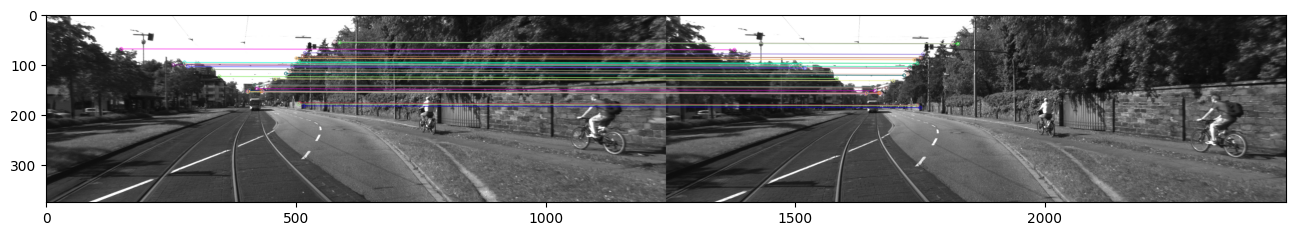

In [38]:
image_left = np.array(data.get_cam0(0))
image_right = np.array(data.get_cam1(1))
image_plus1 = np.array(data.get_cam0(1))
start = datetime.datetime.now()
kp0, des0 = extract_features(image_left, 'orb', mask)
kp1, des1 = extract_features(image_plus1, 'orb', mask)
matches = match_features(des0, des1, matching='BF', detector='orb', sort=False)
print('Number of matches before filtering: ', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering: ', len(matches))
end = datetime.datetime.now()
print('Time to match and filter: ', end-start)
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [39]:
print(len(list(data.cam0)))

77


In [41]:
def estimate_motion(matches, kp1, kp2, k, depth1, max_depth=3000):
    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in matches])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    cx = k[0, 2]
    cy = k[1, 2]
    fx = k[0, 0]
    fy = k[1, 1]
    
    object_points = np.zeros((0, 3))
    delete = []
    
    for i, (u, v) in enumerate(image1_points):
        z = depth1[int(round(v)), int(round(u))]
        
        if z > max_depth:
            delete.append(i)
            continue
            
        x = z * (u - cx) / fx
        y = z * (v - cy) / fy
        object_points = np.vstack([object_points, np.array([x, y, z])])
        #object_points = np.vstack([obeject_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])
        
    image1_points = np.delete(image1_points, delete, 0)
    image2_points = np.delete(image2_points, delete, 0)
    
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    rmat = cv2.Rodrigues(rvec)[0]
    
    return rmat, tvec, image1_points, image2_points

In [42]:
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(P0)
k

array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]])

In [43]:
rmat, tvec, image1_points, image2_points = estimate_motion(matches, kp0, kp1, k, depth)
print("Rotation Matrix:")
print(rmat.round(4))
print("Translation Vector:")
print(tvec.round(4))

Rotation Matrix:
[[ 1.     -0.0012 -0.0044]
 [ 0.0012  1.      0.0059]
 [ 0.0044 -0.0059  1.    ]]
Translation Vector:
[[ 4.000e-04]
 [ 7.700e-03]
 [-9.476e-01]]
